Importing the required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Reading the data

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
heart_data= pd.read_csv(io.BytesIO(uploaded['heart.csv']))


Saving heart.csv to heart (1).csv


Splitting training and testing sets

In [ ]:
from sklearn.model_selection import train_test_split
def train_test_splitting(data, test_size):
  train, test=train_test_split(data, test_size=test_size, random_state=12)
  label_train=train['target']
  label_test=test['target']
  train=train.drop('target',axis=1)
  test=test.drop('target',axis=1)
  return train, test, label_train,label_test

heart_train, heart_test, train_labels, test_labels= train_test_splitting(heart_data,0.2)

Looking at the data

In [ ]:
print(len(heart_train))

242


In [ ]:
heart_train.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [ ]:
heart_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
238,77,1,0,125,304,0,0,162,1,0.0,2,3,2
224,54,1,0,110,239,0,1,126,1,2.8,1,1,3
31,65,1,0,120,177,0,1,140,0,0.4,2,0,3
139,64,1,0,128,263,0,1,105,1,0.2,1,1,3
47,47,1,2,138,257,0,0,156,0,0.0,2,0,2


Visualizing the corelation coefficient matrix to get insights on features

In [ ]:
Corelation_matrix=np.corrcoef(heart_data)
print(Corelation_matrix)

[[1.         0.98747884 0.98844387 ... 0.99496075 0.97174986 0.99484688]
 [0.98747884 1.         0.99547137 ... 0.97572765 0.94514869 0.99670729]
 [0.98844387 0.99547137 1.         ... 0.9859562  0.96833014 0.99588809]
 ...
 [0.99496075 0.97572765 0.9859562  ... 1.         0.98994094 0.98772805]
 [0.97174986 0.94514869 0.96833014 ... 0.98994094 1.         0.96101971]
 [0.99484688 0.99670729 0.99588809 ... 0.98772805 0.96101971 1.        ]]


 Adding a new feature - ratio of maximum heart beat achieved to cholestrol

In [ ]:
heart_train['max_heart_beat_cholestrol_ratio']=heart_train['thalach']/heart_train['chol']
heart_test['max_heart_beat_cholestrol_ratio']=heart_test['thalach']/heart_test['chol']

Visualizing the no.of disease people

In [ ]:
print(train_labels)

238    0
224    0
31     1
139    1
47     1
      ..
259    0
130    1
241    0
253    0
155    1
Name: target, Length: 242, dtype: int64


Upsampling minority(disease) people

In [ ]:
from sklearn.utils import resample
train_full=pd.concat([heart_train,train_labels],axis=1)
no_disease=train_full[train_full.target==0]
disease=train_full[train_full.target==1]
h_upsample=resample(disease,replace=True,n_samples=len(no_disease),random_state=12)
h_upsample_merged=pd.concat([no_disease,h_upsample])
train_labels=h_upsample_merged['target']
train_data=h_upsample_merged.drop('target',axis=1)

Feature Scaling of both training and testing set

In [ ]:
from sklearn.preprocessing import StandardScaler
standard_scaler=StandardScaler()
temp=train_data
train_data=pd.DataFrame(standard_scaler.fit_transform(train_data),columns=temp.columns)
test_data=pd.DataFrame(standard_scaler.fit_transform(heart_test),columns=temp.columns)

Function to calculate error rate

In [ ]:
def error_rate_calc(predicted, actual):
  count=0
  for i in range(len(predicted)):
    if(np.array(predicted)[i]!=np.array(actual)[i]):
      count+=1
  return count*100/len(predicted)

Function to find the confusion matrix and visualize it

In [ ]:
def confusion_matrix(pred,actual):
  from sklearn.metrics import confusion_matrix
  cf_mat=confusion_matrix(pred,actual)
  print(cf_mat)
  sns.heatmap(cf_mat, annot=True)
  plt.show()

Function to calculate Precision,Recall and F1 score

In [ ]:
def precision_recall_calc(pred, actual):
  from sklearn.metrics import precision_score, recall_score
  prec_score=precision_score(pred,actual)
  recall_score=recall_score(pred,actual)
  from sklearn.metrics import f1_score
  f1score=f1_score(pred,actual)
  print("Precision is {0}".format(prec_score))
  print("Recall is {0}".format(recall_score))
  print("F1 score is {0}".format(f1score))

## Training the data on Linear SVM classifier

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(random_state=12)
sgd_clf.fit(train_data,train_labels)
pred_SVM=sgd_clf.predict(train_data)

Checking the error rate on Linear SVM classifier

In [ ]:
error_rate_SVM_train=error_rate_calc(pred_SVM,train_labels)
print("Error rate for Linear SVM classifier on training set is {0}".format(error_rate_SVM_train))
pred_test_Linear_SVM=sgd_clf.predict(test_data)
error_rate_SVM_test=error_rate_calc(pred_test_Linear_SVM,test_labels)
print("Error rate for Linear SVM classifier on test set is {0}".format(error_rate_SVM_test))

Error rate for Linear SVM classifier on training set is 12.616822429906541
Error rate for Linear SVM classifier on test set is 21.311475409836067


Confusion matrix of Linear SVM classifier

[[24  6]
 [ 7 24]]


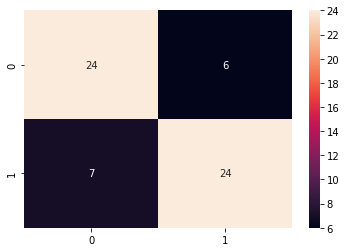

In [ ]:
confusion_matrix(pred_test_Linear_SVM,test_labels)

In [ ]:
precision_recall_calc(pred_test_Linear_SVM,test_labels)

Precision is 0.8
Recall is 0.7741935483870968
F1 score is 0.7868852459016393


## Training the data on RBF Kernel SVM classifier

In [ ]:
from sklearn.svm import SVC
RBF_SVM=SVC(kernel='rbf',gamma='auto')
RBF_SVM.fit(train_data,train_labels)
pred_RBF=RBF_SVM.predict(train_data)

Checking the error rate on RBF SVM classifier

In [ ]:
error_rate_RBF_train=error_rate_calc(pred_RBF,train_labels)
print("Error rate for RBF SVM classifier on training set is {0}".format(error_rate_RBF_train))
pred_test_RBF_SVM=RBF_SVM.predict(test_data)
error_rate_RBF_test=error_rate_calc(pred_test_RBF_SVM,test_labels)
print("Error rate for RBF SVM classifier on test set is {0}".format(error_rate_RBF_test))

Error rate for RBF SVM classifier on training set is 5.140186915887851
Error rate for RBF SVM classifier on test set is 32.78688524590164


Plotting the heat map and Confusion matrix

[[22 11]
 [ 9 19]]


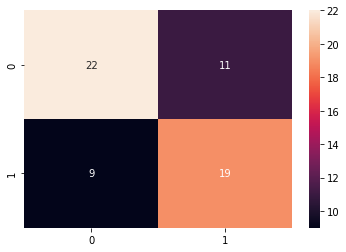

In [ ]:
confusion_matrix(pred_test_RBF_SVM,test_labels)

Precision Recall score for RBF SVM classifier

In [ ]:
precision_recall_calc(pred_test_RBF_SVM,test_labels)

Precision is 0.6333333333333333
Recall is 0.6785714285714286
F1 score is 0.6551724137931035


### Data is overfitting when RBF Kernel is used

## Training the data on logistic regression classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
logistic_clf=LogisticRegression()
logistic_clf.fit(train_data,train_labels)
pred_Logistic=logistic_clf.predict(train_data)

Checking the error rate on logistic regression classifier

In [ ]:
error_rate_logistic_train=error_rate_calc(pred_Logistic,train_labels)
print("Error rate for logistic regression classifier on training set is {0}"
.format(error_rate_logistic_train))
pred_test_logistic=logistic_clf.predict(test_data)
error_rate_logistic=error_rate_calc(pred_test_logistic,test_labels)
print("Error rate for logistic regession classifier on test set is {0}"
.format(error_rate_logistic))

Error rate for logistic regression classifier on training set is 10.280373831775702
Error rate for logistic regession classifier on test set is 22.950819672131146


Confusion matrix- heat map plotting 

[[25  8]
 [ 6 22]]


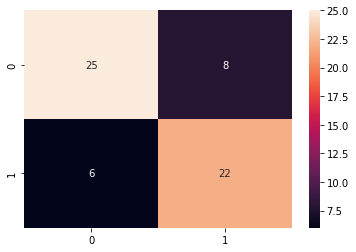

In [ ]:
confusion_matrix(pred_test_logistic,test_labels)

Precision Recall score for logistic regession classifier

In [ ]:
precision_recall_calc(pred_test_logistic,test_labels)

Precision is 0.7333333333333333
Recall is 0.7857142857142857
F1 score is 0.7586206896551724


## Training the data on Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(train_data, train_labels)
pred_Random_forest=forest_clf.predict(train_data)

Checking the error rate on Random Forest classifier

In [ ]:
error_rate_forest_train=error_rate_calc(pred_Random_forest,train_labels)
print("Error rate for Random Forest classifier on training set is {0}"
.format(error_rate_forest_train))
pred_test_forest=forest_clf.predict(test_data)
error_rate_forest=error_rate_calc(pred_test_forest,test_labels)
print("Error rate for Random Forest classifier on test set is {0}"
.format(error_rate_forest))

Error rate for Random Forest classifier on training set is 0.0
Error rate for Random Forest classifier on test set is 21.311475409836067


Precision Recall score for Random Forest classifier

In [ ]:
precision_recall_calc(pred_test_forest,test_labels)

Precision is 0.7333333333333333
Recall is 0.8148148148148148
F1 score is 0.7719298245614035


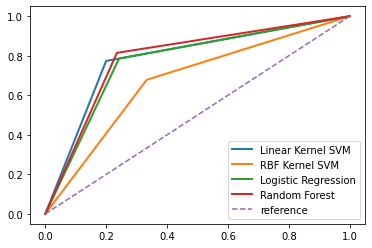

In [ ]:
#ROC Curves for SGD, Logistic and Random Forests
from sklearn.metrics import roc_curve
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
fpr_sgd,tpr_sgd,thresh_sgd=roc_curve(pred_test_Linear_SVM,test_labels)
fpr_rbf, tpr_rbf,thresh_rbf=roc_curve(pred_test_RBF_SVM,test_labels)
fpr_log,tpr_log,thresh_log=roc_curve(pred_test_logistic,test_labels)
fpr_forest,tpr_forest,thresh_forest=roc_curve(pred_test_forest,test_labels)
plot_roc_curve(fpr_sgd,tpr_sgd,label='Linear Kernel SVM')
plot_roc_curve(fpr_rbf,tpr_rbf,label='RBF Kernel SVM')
plot_roc_curve(fpr_log,tpr_log,label='Logistic Regression')
plot_roc_curve(fpr_forest,tpr_forest,label='Random Forest')
plt.plot([0,1],[0,1],'--',label='reference')
plt.legend()
plt.show()


THUS, AS WE CAN SEE, RANDOM FORESTS PERFORM BETTER THAN LOGISTIC, RBF KERNEL SVM and LINEAR SVM 
CLASSIFIER.